<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each_Cluster_Test_300W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Improve accuracy:

```
1. Move top1 towards top2 by 1/4

```

* Ablation study

```
1. Anneal range (1-3 or 1-100)
2. Leaf Node dimension
3. Number of Trees
4. Stack Hourglass or One Hourglass
```

In [1]:
!nvidia-smi

Mon Jul 26 03:27:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

# 1. Initialize

In [3]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['__pycache__',
 'utils',
 'datasets',
 'trained_models',
 'checkpoints',
 'Landmarks_Correlation.ipynb',
 'DataPreprocessing_Helen_300W.ipynb',
 'DataPreprocessing_AFW_300W.ipynb',
 'DataPreprocessing_LFPW_300W.ipynb',
 'DataPreprocessing_IBUG_300W.ipynb',
 'DataPreprocessing_Merge_300W.ipynb',
 'Untitled0.ipynb',
 'Useless notebooks',
 'DataPreprocessing_COFW.ipynb',
 'Train_on_Common2',
 '0000_Converged.ipynb',
 'Fit_Full_Eyes.ipynb',
 'Fit_Common_Eyes.ipynb',
 'Final_Datasets',
 'Train_on_Common',
 'Heatmap_each_Cluster_Test_300W.ipynb',
 'check_leafq',
 'Heatmap_each_Cluster_Train_300W.ipynb',
 'leaf_q_Round1.pt',
 'Decomp_HGNet_Round1.pt']

In [4]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from utils.hourglass import *
from utils.dataloader300w import *

In [6]:
variance_gaussian = 3
dim_tree = 9
num_tree = 8
num_fc = num_tree*(2**(dim_tree-1)-1)
nleaf = num_tree*(2**(dim_tree-1))
print("Leaf Node Number: ", nleaf,"\n")

Leaf Node Number:  2048 



# 2. Data Loader - Test

In [7]:
w300_commonset = W300_set(dataset_type="common", var=3)
common_dataloder = DataLoader(w300_commonset, batch_size=10, pin_memory=True)
w300_challengingset = W300_set(dataset_type="challenging", var=3)
challenging_dataloder = DataLoader(w300_challengingset, batch_size=10, pin_memory=True)

Loading [1/554] pictures......
Loading [100/554] pictures......
Loading [200/554] pictures......
Loading [300/554] pictures......
Loading [400/554] pictures......
Loading [500/554] pictures......
Loading [1/135] pictures......
Loading [100/135] pictures......


# 3. Functions

In [8]:
def leaf_direction(N):
  # this function is called in function 'phi'
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [9]:
def split_tree(up,here,which=0,mode='Second'):
  # this function is called in function 'phi'
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [10]:
def split_base(N):
  # this function is called in function 'phi'
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [11]:
def phi_one(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,nleaf).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)
  tree_ind = split_base(dim_tree-1)
  X, Y = tree_ind.shape

  for ind_tree in range(num_tree):
    for x in range(X):
      for y in range(Y):
        here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
        if y == 0:
          up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
        else:
          up = split_tree(up,here,which=direction[x,y])
        #print('y',y,'up',up)

      out[:,ind_tree*X+x] = up
  out = out/torch.sum(out,axis=1,keepdims=True)
  return out

In [12]:
def find_coord(prob_map, P):
  # prob_map(200,68*256*256)
  # P: number of points
  N = prob_map.shape[0]

  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [13]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [14]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [15]:
def loss_alogb(B, q, p, l):
  np = q.shape[1]
  pred = torch.matmul(p,q.reshape(q.shape[0],-1)).reshape(B*np,-1)
  pred = pred/(torch.sum(pred,axis=1,keepdims=True)+1e-8)
  l = l.reshape(B*np,-1)
  l = l/(torch.sum(l,axis=1,keepdims=True)+1e-8)

  return -torch.sum(l*torch.log(pred))/B

# 4. Test

## 4.1 Restore from saved weights

In [28]:
Decomp_HGNet = Decomp_HGNet_Full(nfc=num_fc).to(device)

orig_dict = torch.load("Decomp_HGNet_Round1.pt")
new_dict = {}

for orig_key in orig_dict.keys():
  new_key = orig_key[7::]
  new_dict[new_key] = orig_dict[orig_key]

Decomp_HGNet.load_state_dict(new_dict)

leaf_q = torch.load("leaf_q_Round1.pt")

## 4.2 Test images

In [29]:
prob_common = torch.zeros(554*68,nleaf).to(device)
prob_common_select = torch.zeros(554*68,nleaf).to(device)
coord_common_label = torch.zeros(554,136).to(device)

prob_challenging = torch.zeros(135*68,nleaf).to(device)
prob_challenging_select = torch.zeros(135*68,nleaf).to(device)
coord_challenging_label = torch.zeros(135,136).to(device)

with torch.no_grad():
  ind_start = 0
  for i, (img,coord,_) in enumerate(common_dataloder):
    img = img.float().to(device)
    coord = coord.float().to(device)
    B = img.shape[0]
    
    outputs = Decomp_HGNet.forward(img)
    prob_common[ind_start*68:int(ind_start+B)*68,:] = phi_one(outputs)
    prob_common_select[ind_start*68:int(ind_start+B)*68,:] = phi_one(outputs, mode='test')
    coord_common_label[ind_start:int(ind_start+B),:] = coord.reshape(B,-1)
    ind_start += B

    if (i+1)%10==0:
      print("Common dataset, processing...... ",(i+1)*10,"/ 554")
  print("Common dataset evaluation finished \n")
  

  ind_start = 0
  for i, (img,coord,_) in enumerate(challenging_dataloder):
    img = img.float().to(device)
    coord = coord.float().to(device)
    B = img.shape[0]
    
    outputs = Decomp_HGNet.forward(img)
    prob_challenging[ind_start*68:int(ind_start+B)*68,:] = phi_one(outputs)
    prob_challenging_select[ind_start*68:int(ind_start+B)*68,:] = phi_one(outputs, mode='test')
    coord_challenging_label[ind_start:int(ind_start+B),:] = coord.reshape(B,-1)
    ind_start += B

    if (i+1)%5==0 or i==0:
      print("Challenging dataset, processing...... ",(i+1)*10,"/ 135")
  print("Challenging dataset evaluation finished")

Common dataset, processing......  100 / 554
Common dataset, processing......  200 / 554
Common dataset, processing......  300 / 554
Common dataset, processing......  400 / 554
Common dataset, processing......  500 / 554
Common dataset evaluation finished 

Challenging dataset, processing......  10 / 135
Challenging dataset, processing......  50 / 135
Challenging dataset, processing......  100 / 135
Challenging dataset evaluation finished


In [30]:
coord_common = find_coord(torch.matmul(prob_common, leaf_q).reshape(554,-1), P=68) #(554,68*2)
coord_common_select = find_coord(torch.matmul(prob_common_select, leaf_q).reshape(554,-1), P=68)

coord_challenging = find_coord(torch.matmul(prob_challenging, leaf_q).reshape(135,-1), P=68)
coord_challenging_select = find_coord(torch.matmul(prob_challenging_select, leaf_q).reshape(135,-1), P=68)

## 4.3 NME

In [31]:
def Pupil(coord):
  # coord(N,68*2)
  # eye centers
  x = coord[:,::2]
  y = coord[:,1::2]
  lx = torch.sum(x[:,36:42],axis=1)/6
  ly = torch.sum(y[:,36:42],axis=1)/6
  rx = torch.sum(x[:,42:48],axis=1)/6
  ry = torch.sum(x[:,42:48],axis=1)/6

  return torch.sqrt((lx - rx)**2 + (ly - ry)**2)

In [32]:
def Ocular(coord):
  # coord(N,68*2)
  # outer eye corners
  x = coord[:,::2]
  y = coord[:,1::2]
  
  return torch.sqrt((x[:,36] - x[:,45])**2 + (y[:,36] - y[:,45])**2)

In [33]:
def NME_pupil(pred_coord, label_coord):
  x = pred_coord[:,::2]
  y = pred_coord[:,1::2]
  x_label = label_coord[:,::2]
  y_label = label_coord[:,1::2]
  pupil = Pupil(label_coord)

  Err = torch.sum(torch.sqrt((x-x_label)**2 + (y-y_label)**2), axis=1)/pupil#.reshape(-1,1)
  return Err*100/68     # percentage already

def NME_ocular(pred_coord, label_coord):
  x = pred_coord[:,::2]
  y = pred_coord[:,1::2]
  x_label = label_coord[:,::2]
  y_label = label_coord[:,1::2]
  ocular = Ocular(label_coord)

  Err = torch.sum(torch.sqrt((x-x_label)**2 + (y-y_label)**2), axis=1)/ocular#.reshape(-1,1)
  return Err*100/68     # percentage already

In [34]:
NME_pupil_common = NME_pupil(coord_common, coord_common_label)
NME_ocular_common = NME_ocular(coord_common, coord_common_label)
NME_pupil_challenging = NME_pupil(coord_challenging, coord_challenging_label)
NME_ocular_challenging = NME_ocular(coord_challenging, coord_challenging_label)

NME_pupil_common_select = NME_pupil(coord_common_select, coord_common_label)
NME_ocular_common_select = NME_ocular(coord_common_select, coord_common_label)
NME_pupil_challenging_select = NME_pupil(coord_challenging_select, coord_challenging_label)
NME_ocular_challenging_select = NME_ocular(coord_challenging_select, coord_challenging_label)

# NME_pupil_common_select = torch.tensor([0]).to(device)
# NME_ocular_common_select = torch.tensor([0]).to(device) 
# NME_pupil_challenging_select = torch.tensor([0]).to(device) 
# NME_ocular_challenging_select = torch.tensor([0]).to(device) 

In [35]:
print("Common Test Set:")
print("    NME Pupil: %.4f, after selection: %.4f" %(torch.sum(NME_pupil_common).item()/554, torch.sum(NME_pupil_common_select).item()/554))
print("    NME Ocular: %.4f, after selection: %.4f \n" %(torch.sum(NME_ocular_common).item()/554, torch.sum(NME_ocular_common_select).item()/554))
print("Challenging Test Set:")
print("    NME Pupil: %.4f, after selection: %.4f" %(torch.sum(NME_pupil_challenging).item()/135, torch.sum(NME_pupil_challenging_select).item()/135))
print("    NME Ocular: %.4f, after selection: %.4f" %(torch.sum(NME_ocular_challenging).item()/135, torch.sum(NME_ocular_challenging_select).item()/135))

Common Test Set:
    NME Pupil: 28.1390, after selection: 28.2524
    NME Ocular: 30.8387, after selection: 30.9621 

Challenging Test Set:
    NME Pupil: 42.8374, after selection: 42.9125
    NME Ocular: 42.5207, after selection: 42.5975


## 4.4 Visualize

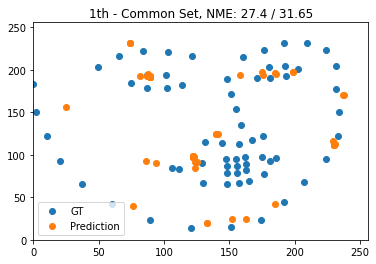

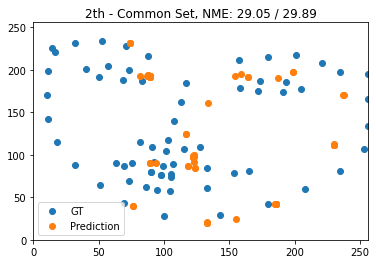

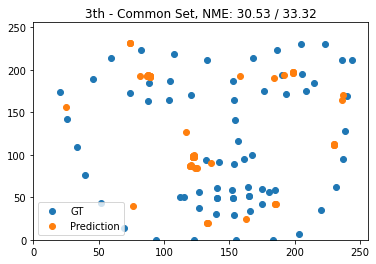

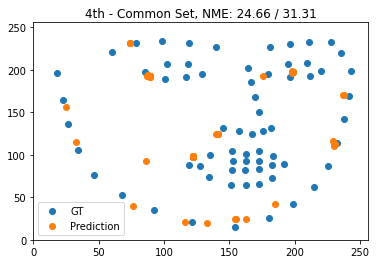

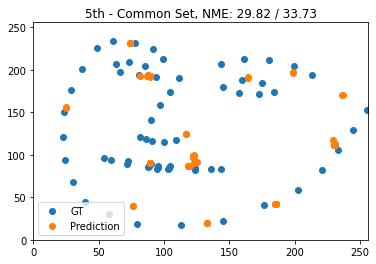

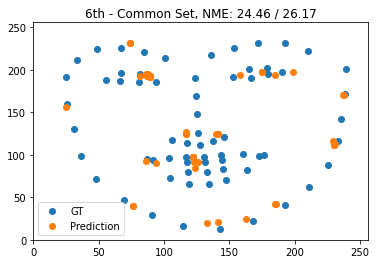

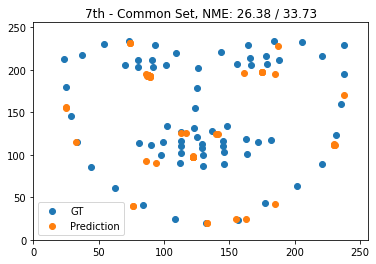

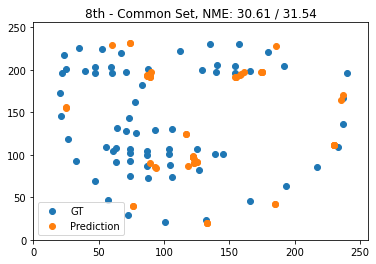

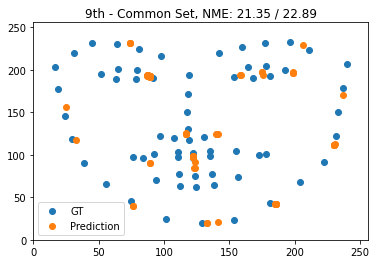

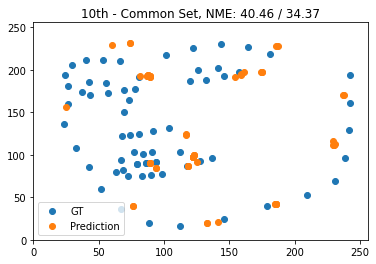

In [36]:
# Coords

for ith in range(10): # range from 0 to 553
  x2 = coord_common_label[ith,::2].detach().cpu()
  y2 = coord_common_label[ith,1::2].detach().cpu()
  plt.scatter(x2,256-y2,label="GT")

  x = coord_common[ith,::2].detach().cpu()
  y = coord_common[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction")

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith+1)+"th - Common Set, NME: "+str(NME_pupil_common[ith].item()*100//1/100)+" / "+str(NME_ocular_common[ith].item()*100//1/100))
  plt.show()

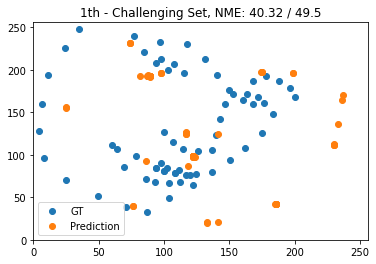

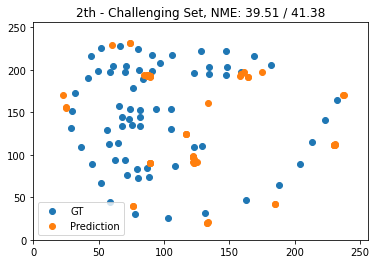

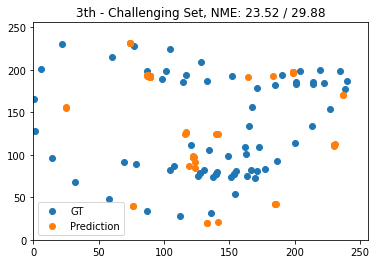

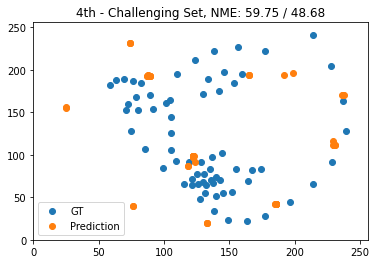

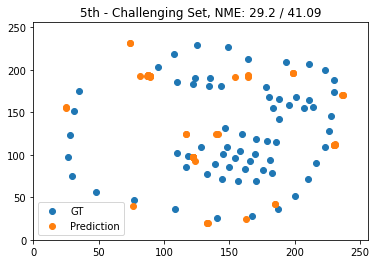

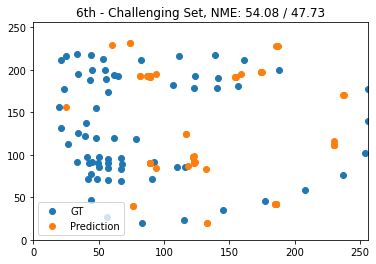

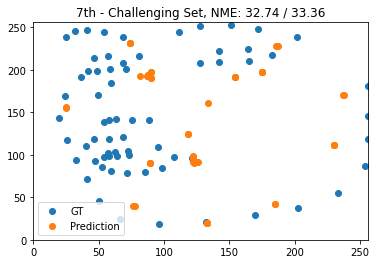

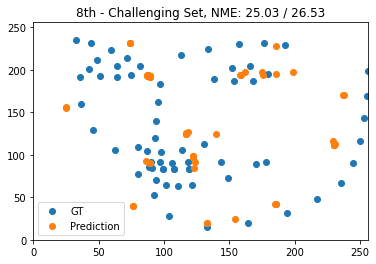

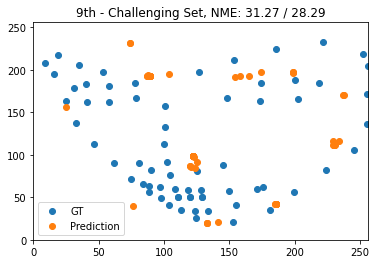

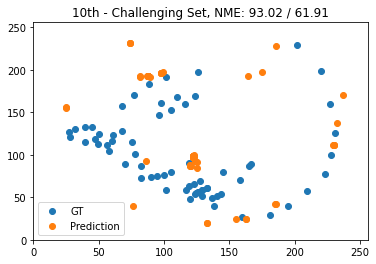

In [52]:
# Coords

for ith in range(10): # range from 0 to 135
  x2 = coord_challenging_label[ith,::2].detach().cpu()
  y2 = coord_challenging_label[ith,1::2].detach().cpu()
  plt.scatter(x2,256-y2,label="GT")

  x = coord_challenging[ith,::2].detach().cpu()
  y = coord_challenging[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction")

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith+1)+"th - Challenging Set, NME: "+str(NME_pupil_challenging[ith].item()*100//1/100)+" / "+str(NME_ocular_challenging[ith].item()*100//1/100))
  plt.show()

## 4.5 Failure rate

In [38]:
fr_threshold = 8

In [39]:
fr_common_pupil = (torch.sum(NME_pupil_common>fr_threshold)/554).item()*100
fr_common_pupil_select = (torch.sum(NME_pupil_common_select>fr_threshold)/554).item()*100
fr_common_ocular = (torch.sum(NME_ocular_common>fr_threshold)/554).item()*100
fr_common_ocular_select = (torch.sum(NME_ocular_common_select>fr_threshold)/554).item()*100

fr_challenging_pupil = (torch.sum(NME_pupil_challenging>fr_threshold)/135).item()*100
fr_challenging_pupil_select = (torch.sum(NME_pupil_challenging_select>fr_threshold)/135).item()*100
fr_challenging_ocular = (torch.sum(NME_ocular_challenging>fr_threshold)/135).item()*100
fr_challenging_ocular_select = (torch.sum(NME_ocular_challenging_select>fr_threshold)/135).item()*100

In [40]:
print("Common Test Set:")
print("    Failure Rate Pupil: %.4f, after selection: %.4f" %(fr_common_pupil, fr_common_pupil_select))
print("    Failure Rate Ocular: %.4f, after selection: %.4f \n" %(fr_common_ocular, fr_common_ocular_select))
print("Challenging Test Set:")
print("    Failure Rate Pupil: %.4f, after selection: %.4f" %(fr_challenging_pupil, fr_challenging_pupil_select))
print("    Failure Rate Ocular: %.4f, after selection: %.4f" %(fr_challenging_ocular, fr_challenging_ocular_select))

Common Test Set:
    Failure Rate Pupil: 100.0000, after selection: 100.0000
    Failure Rate Ocular: 100.0000, after selection: 100.0000 

Challenging Test Set:
    Failure Rate Pupil: 100.0000, after selection: 100.0000
    Failure Rate Ocular: 100.0000, after selection: 100.0000


## 4.6 AUC

Text(0.5, 1.0, 'AUC Common pupil, AUC = 0.718')

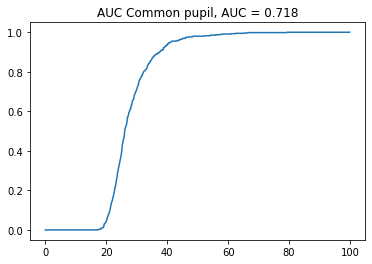

In [41]:
AUC_FR = torch.arange(0,100,0.1).to(device)
nfail = torch.zeros(AUC_FR.shape).to(device)

i = 0
auc_pupil_common = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_pupil_common<=auc_fr)/554).item()
  auc_pupil_common+=0.1*nfail[i]
  i+=1
  
auc_pupil_common = auc_pupil_common.item()*10//1/1000
plt.plot(AUC_FR.cpu(), nfail.cpu())
plt.title("AUC Common pupil, AUC = "+str(auc_pupil_common))

Text(0.5, 1.0, 'AUC Common ocular, AUC = 0.691')

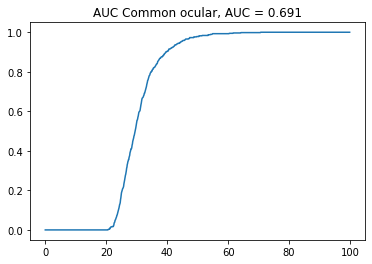

In [42]:
AUC_FR = torch.arange(0,100,0.1).to(device)
nfail = torch.zeros(AUC_FR.shape).to(device)

i = 0
auc_ocular_common = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_ocular_common<=auc_fr)/554).item()
  auc_ocular_common+=0.1*nfail[i]
  i+=1
  
auc_ocular_common = auc_ocular_common.item()*10//1/1000
plt.plot(AUC_FR.cpu(), nfail.cpu())
plt.title("AUC Common ocular, AUC = "+str(auc_ocular_common))

Text(0.5, 1.0, 'AUC Challenging pupil, AUC = 0.572')

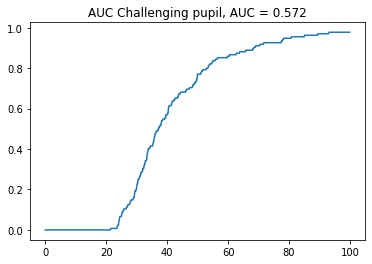

In [43]:
AUC_FR = torch.arange(0,100,0.1).to(device)
nfail = torch.zeros(AUC_FR.shape).to(device)

i = 0
auc_pupil_challenging = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_pupil_challenging<=auc_fr)/135).item()
  auc_pupil_challenging+=0.1*nfail[i]
  i+=1
  
auc_pupil_challenging = auc_pupil_challenging.item()*10//1/1000
plt.plot(AUC_FR.cpu(), nfail.cpu())
plt.title("AUC Challenging pupil, AUC = "+str(auc_pupil_challenging))

Text(0.5, 1.0, 'AUC Challenging ocular, AUC = 0.574')

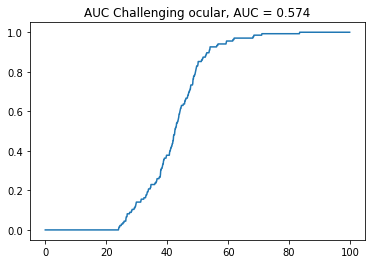

In [44]:
AUC_FR = torch.arange(0,100,0.1).to(device)
nfail = torch.zeros(AUC_FR.shape).to(device)

i = 0
auc_ocular_challenging = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_ocular_challenging<=auc_fr)/135).item()
  auc_ocular_challenging+=0.1*nfail[i]
  i+=1
  
auc_ocular_challenging = auc_ocular_challenging.item()*10//1/1000
plt.plot(AUC_FR.cpu(), nfail.cpu())
plt.title("AUC Challenging ocular, AUC = "+str(auc_ocular_challenging))

In [45]:
i = 0
auc_pupil_common_select = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_pupil_common_select<=auc_fr)/554).item()
  auc_pupil_common_select+=0.1*nfail[i]
  i+=1
auc_pupil_common_select = auc_pupil_common_select.item()*10//1/1000



i = 0
auc_ocular_common_select = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_ocular_common_select<=auc_fr)/554).item()
  auc_ocular_common_select+=0.1*nfail[i]
  i+=1
auc_ocular_common_select = auc_ocular_common_select.item()*10//1/1000



i = 0
auc_pupil_challenging_select = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_pupil_challenging_select<=auc_fr)/135).item()
  auc_pupil_challenging_select+=0.1*nfail[i]
  i+=1
auc_pupil_challenging_select = auc_pupil_challenging_select.item()*10//1/1000



i = 0
auc_ocular_challenging_select = 0
for auc_fr in AUC_FR:
  nfail[i] = (torch.sum(NME_ocular_challenging_select<=auc_fr)/135).item()
  auc_ocular_challenging_select+=0.1*nfail[i]
  i+=1
auc_ocular_challenging_select = auc_ocular_challenging_select.item()*10//1/1000

In [46]:
print("Common Test Set:")
print("    AUC Pupil: %.4f, after selection: %.4f" %(auc_pupil_common, auc_pupil_common_select))
print("    AUC Ocular: %.4f, after selection: %.4f \n" %(auc_ocular_common, auc_ocular_common_select))
print("Challenging Test Set:")
print("    AUC Pupil: %.4f, after selection: %.4f" %(auc_pupil_challenging, auc_pupil_challenging_select))
print("    AUC Ocular: %.4f, after selection: %.4f" %(auc_ocular_challenging, auc_ocular_challenging_select))

Common Test Set:
    AUC Pupil: 0.7180, after selection: 0.7170
    AUC Ocular: 0.6910, after selection: 0.6890 

Challenging Test Set:
    AUC Pupil: 0.5720, after selection: 0.5710
    AUC Ocular: 0.5740, after selection: 0.5730


# Summary

In [47]:
print("NME:")
print("   Common Test Set:")
print("      Pupil: %.4f, after selection: %.4f" %(torch.sum(NME_pupil_common).item()/554, torch.sum(NME_pupil_common_select).item()/554))
print("      Ocular: %.4f, after selection: %.4f" %(torch.sum(NME_ocular_common).item()/554, torch.sum(NME_ocular_common_select).item()/554))
print("   Challenging Test Set:")
print("      Pupil: %.4f, after selection: %.4f" %(torch.sum(NME_pupil_challenging).item()/135, torch.sum(NME_pupil_challenging_select).item()/135))
print("      Ocular: %.4f, after selection: %.4f \n\n" %(torch.sum(NME_ocular_challenging).item()/135, torch.sum(NME_ocular_challenging_select).item()/135))

print("Faulire Rate (threshold =",fr_threshold, "%)")
print("   Common Test Set:")
print("      Pupil: %.4f, after selection: %.4f" %(fr_common_pupil, fr_common_pupil_select))
print("      Ocular: %.4f, after selection: %.4f" %(fr_common_ocular, fr_common_ocular_select))
print("   Challenging Test Set:")
print("      Pupil: %.4f, after selection: %.4f" %(fr_challenging_pupil, fr_challenging_pupil_select))
print("      Ocular: %.4f, after selection: %.4f \n\n" %(fr_challenging_ocular, fr_challenging_ocular_select))


print("AUC")
print("   Common Test Set:")
print("      Pupil: %.4f, after selection: %.4f" %(auc_pupil_common, auc_pupil_common_select))
print("      Ocular: %.4f, after selection: %.4f" %(auc_ocular_common, auc_ocular_common_select))
print("   Challenging Test Set:")
print("      Pupil: %.4f, after selection: %.4f" %(auc_pupil_challenging, auc_pupil_challenging_select))
print("      Ocular: %.4f, after selection: %.4f" %(auc_ocular_challenging, auc_ocular_challenging_select))

NME:
   Common Test Set:
      Pupil: 28.1390, after selection: 28.2524
      Ocular: 30.8387, after selection: 30.9621
   Challenging Test Set:
      Pupil: 42.8374, after selection: 42.9125
      Ocular: 42.5207, after selection: 42.5975 


Faulire Rate (threshold = 8 %)
   Common Test Set:
      Pupil: 100.0000, after selection: 100.0000
      Ocular: 100.0000, after selection: 100.0000
   Challenging Test Set:
      Pupil: 100.0000, after selection: 100.0000
      Ocular: 100.0000, after selection: 100.0000 


AUC
   Common Test Set:
      Pupil: 0.7180, after selection: 0.7170
      Ocular: 0.6910, after selection: 0.6890
   Challenging Test Set:
      Pupil: 0.5720, after selection: 0.5710
      Ocular: 0.5740, after selection: 0.5730


In [48]:
# plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
# plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
# for ith in range(10):
#   plt.imshow(plot_heatmaps_all[ith,:,:])
#   plt.title(str(ith)+"th prediction heatmap")
#   plt.show()

In [49]:
# for nleaf in range(48):
#   plt.imshow(leaf_q.reshape(total_num_leaf_nodes,12,256,256)[nleaf,0,:,:].detach().cpu())
#   plt.title(str(ith)+"th leafnode, first point, first img")
#   plt.show()

In [50]:
# image = torch.sum(hm, axis=1).detach().cpu()
# plt.imshow(image[ith,:,:])

In [51]:
# plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())